# Proyek Klasifikasi Gambar: Animals classification dataset (https://www.kaggle.com/datasets/antobenedetti/animals)
- **Nama:** Muhammad Rizki AL-Fathir
- **Email:** alfthr378@gmail.com
- **ID Dicoding:** PetaniHandal

## Import Semua Packages/Library yang Digunakan

In [1]:
%pip install tensorflow==2.18
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from importlib.metadata import files
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


2025-04-23 10:30:46.995387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745404247.206422      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745404247.272045      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Data Preparation

### Data Loading

loading data menggunakan kaggle

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("antobenedetti/animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals


In [4]:
path = path + '/animals'

In [5]:
path

'/kaggle/input/animals/animals'

### Data Preprocessing

#### Split Dataset

In [6]:
!ls /kaggle/input/animals/animals


inf  train  val


- inf adalah folder untuk example inference
- train adalah data train
- val adalah data val

In [7]:


train_dir = path + "/train"
val_dir = path + "/val"

def count_files_in_dir(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

train_count = count_files_in_dir(train_dir)
val_count = count_files_in_dir(val_dir)

print(f"Number of files in train directory (including subfolders): {train_count}")
print(f"Number of files in val directory (including subfolders): {val_count}")


Number of files in train directory (including subfolders): 13474
Number of files in val directory (including subfolders): 1497


In [8]:
train = 13474
val = 1497
total = train + val

train_percentage = (train_count / total) * 100
val_percentage = (val_count / total) * 100

print(f"Persentase train: {train_percentage:.2f}%")
print(f"Persentase val: {val_percentage:.2f}%")

Persentase train: 90.00%
Persentase val: 10.00%


maka train akan di split kembali dengan proporsi 80/20, sehingga persentase splitting nya sebagai berikut

- 70 train
- 20 val
- 10 test (nama folder bawaan adalah val)

splitting train akan dilakukan dalam validation split di image data generator flow from directory


### Augmentasi data

In [10]:
base_dir = path

# Prepare data generators for model training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split = 2/9 # dari 90% data train, diambil 20% untuk validasi
    random_state=42
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

### Train dan test generator

In [11]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    subset='training',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    subset='validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)
print("\nData generators created successfully.")

Found 10482 images belonging to 5 classes.
Found 2992 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.

Data generators created successfully.


### menampilkan sample image

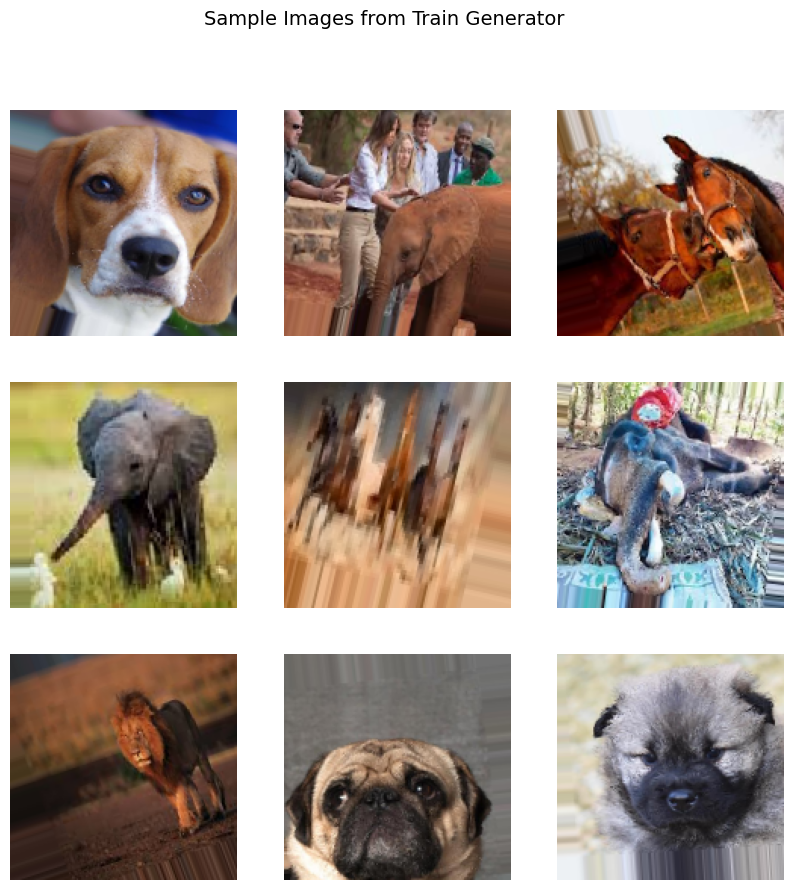

In [12]:
sample_images, sample_labels = next(train_generator)
sample_images = sample_images * 255
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    img = sample_images[i].astype("uint8")
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Sample Images from Train Generator", fontsize=14)
plt.show()


### Menampilkan variasi resolusi

In [13]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(train_dir)

horse: 2705
- (1024, 602)
- (1024, 611)
- (1600, 1320)
- (206, 244)
- (1200, 1200)
- (336, 448)
- (360, 140)
- (177, 284)
- (201, 251)
- (1024, 705)
- (500, 318)
- (1024, 714)
- (627, 1024)
- (276, 183)
- (772, 1024)
- (1024, 723)
- (1024, 970)
- (1024, 741)
- (280, 180)
- (1024, 997)
- (500, 421)
- (272, 185)
- (257, 196)
- (292, 172)
- (500, 439)
- (1024, 835)
- (284, 177)
- (209, 241)
- (600, 800)
- (685, 1024)
- (1024, 700)
- (321, 311)
- (244, 207)
- (1024, 718)
- (233, 216)
- (1024, 727)
- (1299, 941)
- (300, 224)
- (345, 146)
- (1024, 565)
- (1024, 574)
- (1269, 787)
- (1024, 583)
- (325, 155)
- (352, 288)
- (453, 340)
- (383, 132)
- (1024, 686)
- (2521, 1607)
- (1024, 695)
- (221, 228)
- (1024, 704)
- (224, 224)
- (1800, 1200)
- (531, 799)
- (189, 266)
- (276, 182)
- (824, 1024)
- (1088, 725)
- (1024, 960)
- (225, 225)
- (160, 315)
- (320, 215)
- (1024, 578)
- (282, 179)
- (274, 184)
- (294, 171)
- (385, 289)
- (255, 198)
- (286, 176)
- (334, 500)
- (1024, 681)
- (294, 198)
- (

## Modelling

### menggunakan transfer learning dengan finetune mobilenetv2

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [18]:

int_lr = 1e-4
num_epochs = 20

pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

for layer in pre_trained_model.layers[-20:]:
    layer.trainable = True

last_output = pre_trained_model.output
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(last_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)
optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


H = model.fit(train_generator,
              epochs=num_epochs,
              callbacks=[early_stop],
              validation_data = validation_generator)

/tmp/ipykernel_31/1121747675.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
I0000 00:00:1745404490.944333      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745404490.945197      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745404507.993401     128 service.cc:148] XLA service 0x7d94d40043a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745404507.994505     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745404507.994536     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745404509.274774     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/328 ━━━━━━━━━━━━━━━━━━━━ 2:03:33 23s/step - accuracy: 0.4062 - loss: 1.8259

I0000 00:00:1745404516.577604     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


328/328 ━━━━━━━━━━━━━━━━━━━━ 135s 343ms/step - accuracy: 0.6476 - loss: 0.9368 - val_accuracy: 0.8860 - val_loss: 0.3149
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 97s 292ms/step - accuracy: 0.8953 - loss: 0.3260 - val_accuracy: 0.8864 - val_loss: 0.3375
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 99s 296ms/step - accuracy: 0.9207 - loss: 0.2436 - val_accuracy: 0.8707 - val_loss: 0.3942
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 99s 298ms/step - accuracy: 0.9316 - loss: 0.1992 - val_accuracy: 0.9114 - val_loss: 0.2606
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 98s 295ms/step - accuracy: 0.9407 - loss: 0.1743 - val_accuracy: 0.9398 - val_loss: 0.1753
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 98s 295ms/step - accuracy: 0.9424 - loss: 0.1640 - val_accuracy: 0.9432 - val_loss: 0.1664
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 97s 292ms/step - accuracy: 0.9522 - loss: 0.1475 - val_accuracy: 0.9522 - val_loss: 0.1316
Epoch 8/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 98s 294ms/step - accuracy: 0.9561 - loss: 0.1307 - va

## Evaluasi dan Visualisasi

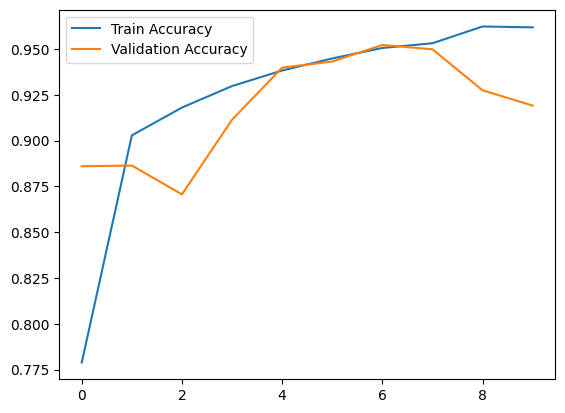

In [19]:
plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


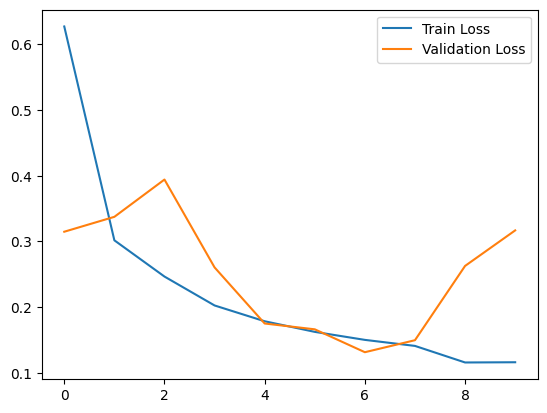

In [20]:
plt.plot(H.history['loss'], label='Train Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [21]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - accuracy: 0.9615 - loss: 0.1122
Test Loss: 0.12269420176744461
Test Accuracy: 0.9579158425331116


In [22]:
loss, accuracy = model.evaluate(validation_generator)

print(f"val Loss: {loss}")
print(f"val Accuracy: {accuracy}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.9544 - loss: 0.1174
val Loss: 0.1312166154384613
val Accuracy: 0.9515374302864075


In [23]:
loss, accuracy = model.evaluate(train_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


328/328 ━━━━━━━━━━━━━━━━━━━━ 82s 250ms/step - accuracy: 0.9630 - loss: 0.1032
Test Loss: 0.0984126403927803
Test Accuracy: 0.9644151926040649


## Konversi Model

In [24]:
model.save('animals_classif.keras')

In [25]:
model = tf.keras.models.load_model('/kaggle/working/animals_classif.keras')

In [26]:
model.export('/kaggle/working/')

Saved artifact at '/kaggle/working/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138079736145168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138082495513616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138082495514576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138082495513424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138082495522640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138082495517072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138082495516880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138082495517648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138082495514384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138082495514000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138082495515536

## Inference (Optional)

Inference akan dilakukan di notebook yang lain